<table class="table table-bordered">
    <tr>
        <th style="text-align:center; width:25%"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 250px; height: 125px; "></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Assignment 2 (Problem 1) - Sentiment Analysis Model  (Group)</h2><h3>AY2021/22 Semester</h3></th>
    </tr>
</table>

In [1]:
# Import the Required Packages
import re
import numpy as np
import pandas as pd
import seaborn as sn
import itertools
from sklearn.metrics import confusion_matrix

import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, GRU, LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
%matplotlib inline

## Step 1 – Data Loading and Processing (Group)

### 1.1 Data Loading

In [19]:
raw_df = pd.read_csv('whatsapp_reviews.csv')
print(raw_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97390 entries, 0 to 97389
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reviewId              97390 non-null  object 
 1   userName              97390 non-null  object 
 2   userImage             97390 non-null  object 
 3   content               97390 non-null  object 
 4   score                 97390 non-null  int64  
 5   thumbsUpCount         97390 non-null  int64  
 6   reviewCreatedVersion  97390 non-null  object 
 7   at                    97390 non-null  object 
 8   replyContent          0 non-null      float64
 9   repliedAt             0 non-null      float64
dtypes: float64(2), int64(2), object(6)
memory usage: 7.4+ MB
None


In [20]:
raw_df.score.value_counts()

1    36100
5    21185
4    14794
3    14191
2    11120
Name: score, dtype: int64

In [21]:
maxData = min(raw_df.score.value_counts())
#Obtain All Category
scores = []
for score in raw_df['score']:
    if score not in scores:
        scores.append(score)
        
tempList = []
for x in scores:
    if (len(raw_df[raw_df['score']==x]) > maxData):  
        temp = raw_df[raw_df['score']==x]
        extraData = len(raw_df[raw_df['score']==x]) - maxData
        temp = temp.head(-extraData)
        tempList.append(temp)
    else:
        tempList.append(raw_df[raw_df['score']==x])
        
stratified_df = pd.concat(tempList)
stratified_df['score'].value_counts()

1    11120
2    11120
3    11120
4    11120
5    11120
Name: score, dtype: int64

In [22]:
df = stratified_df[['content','score']]
df = df.reset_index(drop=True)
df

,content,score
0,VERY IMPORTANT REVIEW. READ THOROUGHLY. Everyt...,3
1,When we message someone and delete it for ever...,3
2,Its so annoying when you want to hear your or ...,3
3,I don't know why but everytime i shut down my ...,3
4,I should not rate one star 🌟 for this app. Whe...,3
...,...,...
55595,Best ever ... Pleass enable us to select among...,4
55596,I can't listen to any voice note since it have...,4
55597,This application is very easy for uses.Is secu...,4
55598,I have an request & Idea for make whatsapp bet...,4


### 1.2 Data Processing


In [35]:
df.head()

,content,score
0,VERY IMPORTANT REVIEW. READ THOROUGHLY. Everyt...,3
1,When we message someone and delete it for ever...,3
2,Its so annoying when you want to hear your or ...,3
3,I don't know why but everytime i shut down my ...,3
4,I should not rate one star 🌟 for this app. Whe...,3


In [7]:
def apos(text):
    Apos_dict={"'s":" is", "can't":"cannot", "won't":"will not", "n't":" not","'m":" am","'ll":" will",
           "'d":" would","'ve":" have","'re":" are"}
    for key,value in Apos_dict.items():
        if key in text:
            text=text.replace(key,value)
    
    return text


def pre_process(text):
    # remove hashtags
    text = re.sub(r'#', '', text)
    
    # convert contractions
    text = apos(text)
    
    # split attached words
    text = " ".join([s for s in re.split("([A-Z][a-z]+[^A-Z]*)",text) if s])
    
    # lowercase
    text = text.lower()
    
    
    return text

df['content'] = df['content'].apply(lambda x:pre_process(x))
df.head()

,content,score
0,very important review. read thoroughly. every...,3
1,when we message someone and delete it for ever...,3
2,its so annoying when you want to hear your or ...,3
3,i do not know why but everytime i shut down my...,3
4,i should not rate one star 🌟 for this app. wh...,3


In [8]:
df['content'][1623]

'an app that could not upgrade its system to support multiple device, even after so many years, cannot be rated high.'

In [9]:
df.to_csv('preprocessed_reviews.csv',index=False)

In [10]:
df = pd.read_csv('preprocessed_reviews.csv')

In [11]:
# Convert the content and scores into numeric tensors
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['content'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 12967 unique tokens.


In [43]:
totalWords = 0
for words in df.content:
    totalWords += len(words)
print(totalWords/(len(df.content)))

193.12025179856116


In [ ]:
maxlen = 200  # We will cut reviews after 200 words
max_words = len(word_index)  # We will use all unique words (vocabulary) in the dataset (dictionary)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['content'])
sequences = tokenizer.texts_to_sequences(df['content'])

data = pad_sequences(sequences, maxlen=maxlen)
print(data)
labels = np.asarray(df['score'])
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
X = data[indices]
y = pd.get_dummies(labels[indices]).values

### 1.3 Data Sampling

In [6]:
# Split the X & y into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('Train Data:',len(X_train))
print('Test Data:',len(X_test))

Train Data: 44480
Test Data: 11120


## Step 2 – Develop a Sentiment Analysis Model (Individual: One Model Per Student)

### Model #1  (Student Name: Gavin Lim)

In [7]:
# Build the Model
model = Sequential()
model.add(Embedding(max_words, 5, input_length=maxlen))
model.add(SimpleRNN(1))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 5)            64835     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 1)                 7         
_________________________________________________________________
dense (Dense)                (None, 5)                 10        
Total params: 64,852
Trainable params: 64,852
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Train the Model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=256,
                    validation_split=0.2)

Train on 35584 samples, validate on 8896 samples
Epoch 1/10
35584/35584 [==============================] - 14s 395us/sample - loss: 1.5564 - acc: 0.3140 - val_loss: 1.5142 - val_acc: 0.3404
Epoch 2/10
35584/35584 [==============================] - 12s 337us/sample - loss: 1.5030 - acc: 0.3348 - val_loss: 1.4949 - val_acc: 0.3253
Epoch 3/10
35584/35584 [==============================] - 12s 334us/sample - loss: 1.4536 - acc: 0.3544 - val_loss: 1.4385 - val_acc: 0.3506
Epoch 4/10
35584/35584 [==============================] - 12s 340us/sample - loss: 1.4103 - acc: 0.3630 - val_loss: 1.4030 - val_acc: 0.3563
Epoch 5/10
35584/35584 [==============================] - 12s 336us/sample - loss: 1.3741 - acc: 0.3706 - val_loss: 1.3732 - val_acc: 0.3606
Epoch 6/10
35584/35584 [==============================] - 12s 338us/sample - loss: 1.3447 - acc: 0.3776 - val_loss: 1.3534 - val_acc: 0.3617
Epoch 7/10
35584/35584 [==============================] - 14s 381us/sample - loss: 1.3190 - acc: 0.3815 -

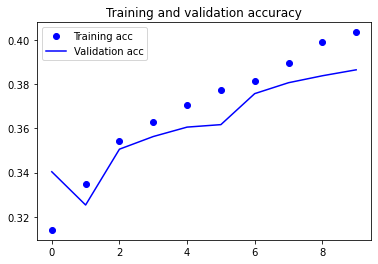

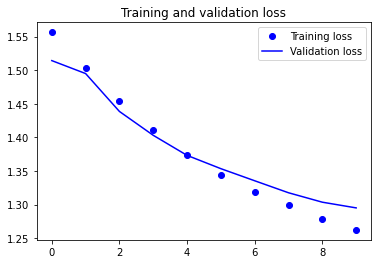

In [9]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [10]:
model = Sequential()
model.add(Embedding(max_words, 16, input_length=maxlen))
model.add(SimpleRNN(16, return_sequences=True))
model.add(SimpleRNN(16))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 16)           207472    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 200, 16)           528       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 85        
Total params: 208,613
Trainable params: 208,613
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_split=0.2)

Train on 35584 samples, validate on 8896 samples
Epoch 1/30
35584/35584 [==============================] - 52s 1ms/sample - loss: 1.3676 - acc: 0.4419 - val_loss: 1.0612 - val_acc: 0.6139
Epoch 2/30
35584/35584 [==============================] - 48s 1ms/sample - loss: 0.8139 - acc: 0.7208 - val_loss: 0.7628 - val_acc: 0.7411
Epoch 3/30
35584/35584 [==============================] - 48s 1ms/sample - loss: 0.5528 - acc: 0.8190 - val_loss: 0.6378 - val_acc: 0.7941
Epoch 4/30
35584/35584 [==============================] - 48s 1ms/sample - loss: 0.4169 - acc: 0.8659 - val_loss: 0.5810 - val_acc: 0.8216
Epoch 5/30
35584/35584 [==============================] - 48s 1ms/sample - loss: 0.3301 - acc: 0.8981 - val_loss: 0.5302 - val_acc: 0.8444
Epoch 6/30
35584/35584 [==============================] - 48s 1ms/sample - loss: 0.2705 - acc: 0.9179 - val_loss: 0.5120 - val_acc: 0.8529
Epoch 7/30
35584/35584 [==============================] - 48s 1ms/sample - loss: 0.2255 - acc: 0.9314 - val_loss: 0.4

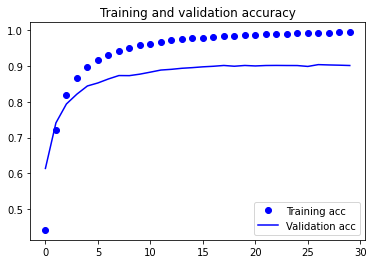

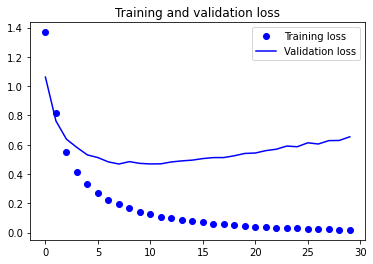

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
model = Sequential()
model.add(Embedding(max_words, 16, input_length=maxlen))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 16)           207472    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 200, 32)           1568      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 200, 32)           2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 213,365
Trainable params: 213,365
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=64,
                    validation_split=0.2)

Train on 35584 samples, validate on 8896 samples
Epoch 1/50
35584/35584 [==============================] - 145s 4ms/sample - loss: 1.2916 - acc: 0.4659 - val_loss: 0.9471 - val_acc: 0.6527
Epoch 2/50
35584/35584 [==============================] - 140s 4ms/sample - loss: 0.7116 - acc: 0.7521 - val_loss: 0.7275 - val_acc: 0.7546
Epoch 3/50
35584/35584 [==============================] - 140s 4ms/sample - loss: 0.4741 - acc: 0.8434 - val_loss: 0.5832 - val_acc: 0.8085
Epoch 4/50
35584/35584 [==============================] - 140s 4ms/sample - loss: 0.3520 - acc: 0.8852 - val_loss: 0.5311 - val_acc: 0.8359
Epoch 5/50
35584/35584 [==============================] - 141s 4ms/sample - loss: 0.2739 - acc: 0.9131 - val_loss: 0.5082 - val_acc: 0.8540
Epoch 6/50
35584/35584 [==============================] - 140s 4ms/sample - loss: 0.2225 - acc: 0.9295 - val_loss: 0.4814 - val_acc: 0.8679
Epoch 7/50
35584/35584 [==============================] - 140s 4ms/sample - loss: 0.1847 - acc: 0.9422 - val_lo

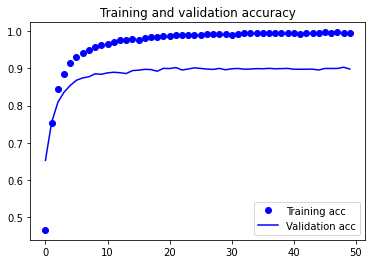

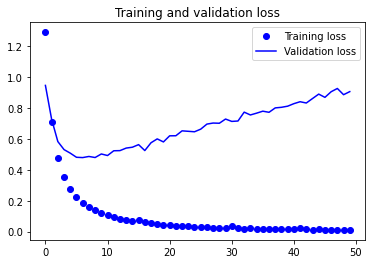

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [16]:
model = Sequential()
model.add(Embedding(max_words, 32, input_length=maxlen))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 32)           414944    
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 200, 32)           2080      
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 200, 32)           2080      
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 165       
Total params: 421,349
Trainable params: 421,349
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.2)

Train on 35584 samples, validate on 8896 samples
Epoch 1/30
35584/35584 [==============================] - 326s 9ms/sample - loss: 1.1440 - acc: 0.5452 - val_loss: 0.8089 - val_acc: 0.7118
Epoch 2/30
35584/35584 [==============================] - 314s 9ms/sample - loss: 0.5735 - acc: 0.8058 - val_loss: 0.6312 - val_acc: 0.7899
Epoch 3/30
35584/35584 [==============================] - 309s 9ms/sample - loss: 0.3753 - acc: 0.8784 - val_loss: 0.5212 - val_acc: 0.8335
Epoch 4/30
35584/35584 [==============================] - 309s 9ms/sample - loss: 0.2738 - acc: 0.9125 - val_loss: 0.5030 - val_acc: 0.8502
Epoch 5/30
35584/35584 [==============================] - 316s 9ms/sample - loss: 0.2103 - acc: 0.9326 - val_loss: 0.4636 - val_acc: 0.8686
Epoch 6/30
35584/35584 [==============================] - 311s 9ms/sample - loss: 0.1680 - acc: 0.9462 - val_loss: 0.4632 - val_acc: 0.8757
Epoch 7/30
35584/35584 [==============================] - 309s 9ms/sample - loss: 0.1374 - acc: 0.9564 - val_lo

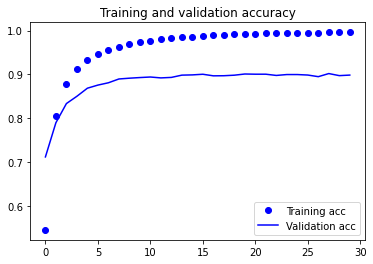

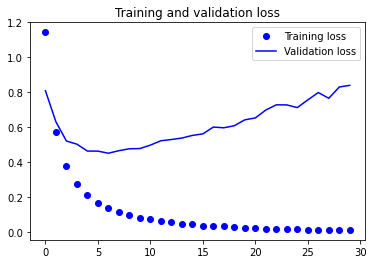

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [19]:
model = Sequential()
model.add(Embedding(max_words, 16, input_length=maxlen))
model.add(SimpleRNN(32, dropout = 0.5, return_sequences=True))
model.add(SimpleRNN(32, dropout = 0.5, return_sequences=True))
model.add(SimpleRNN(32))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 16)           207472    
_________________________________________________________________
simple_rnn_9 (SimpleRNN)     (None, 200, 32)           1568      
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, 200, 32)           2080      
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 165       
Total params: 213,365
Trainable params: 213,365
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2)

Train on 35584 samples, validate on 8896 samples
Epoch 1/20
35584/35584 [==============================] - 331s 9ms/sample - loss: 1.5298 - acc: 0.2953 - val_loss: 1.3395 - val_acc: 0.4426
Epoch 2/20
35584/35584 [==============================] - 329s 9ms/sample - loss: 1.2706 - acc: 0.4738 - val_loss: 1.0995 - val_acc: 0.5804
Epoch 3/20
35584/35584 [==============================] - 327s 9ms/sample - loss: 1.1251 - acc: 0.5559 - val_loss: 0.9928 - val_acc: 0.6275
Epoch 4/20
35584/35584 [==============================] - 330s 9ms/sample - loss: 1.0233 - acc: 0.6106 - val_loss: 0.8761 - val_acc: 0.6793
Epoch 5/20
35584/35584 [==============================] - 333s 9ms/sample - loss: 0.9534 - acc: 0.6408 - val_loss: 0.8277 - val_acc: 0.6956
Epoch 6/20
35584/35584 [==============================] - 332s 9ms/sample - loss: 0.9009 - acc: 0.6664 - val_loss: 0.8065 - val_acc: 0.7063
Epoch 7/20
35584/35584 [==============================] - 331s 9ms/sample - loss: 0.8706 - acc: 0.6788 - val_lo

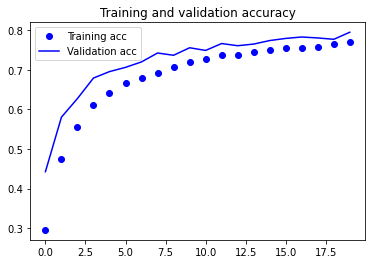

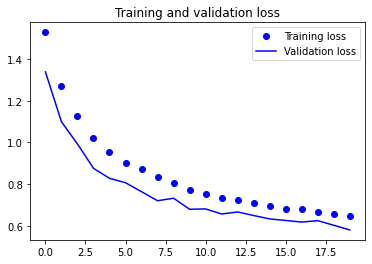

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [6]:
model = Sequential()
model.add(Embedding(max_words, 8, input_length=maxlen))
model.add(SimpleRNN(32, dropout = 0.25, return_sequences=True))
model.add(SimpleRNN(32, dropout = 0.25, return_sequences=True))
model.add(SimpleRNN(32))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 8)            103736    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 200, 32)           1312      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 200, 32)           2080      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 109,373
Trainable params: 109,373
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.2)

Train on 35584 samples, validate on 8896 samples
Epoch 1/30
35584/35584 [==============================] - 333s 9ms/sample - loss: 1.5369 - acc: 0.3015 - val_loss: 1.2623 - val_acc: 0.4945
Epoch 2/30
35584/35584 [==============================] - 329s 9ms/sample - loss: 1.1702 - acc: 0.5386 - val_loss: 0.9960 - val_acc: 0.6275
Epoch 3/30
35584/35584 [==============================] - 328s 9ms/sample - loss: 0.9718 - acc: 0.6327 - val_loss: 0.8477 - val_acc: 0.6900
Epoch 4/30
35584/35584 [==============================] - 327s 9ms/sample - loss: 0.8670 - acc: 0.6841 - val_loss: 0.8107 - val_acc: 0.7114
Epoch 5/30
35584/35584 [==============================] - 328s 9ms/sample - loss: 0.7919 - acc: 0.7111 - val_loss: 0.7416 - val_acc: 0.7334
Epoch 6/30
35584/35584 [==============================] - 328s 9ms/sample - loss: 0.7508 - acc: 0.7307 - val_loss: 0.7046 - val_acc: 0.7500
Epoch 7/30
35584/35584 [==============================] - 328s 9ms/sample - loss: 0.7058 - acc: 0.7463 - val_lo

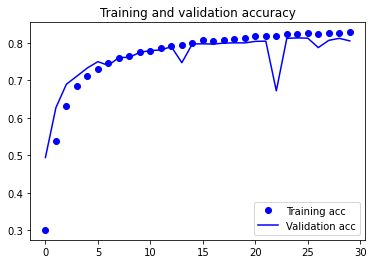

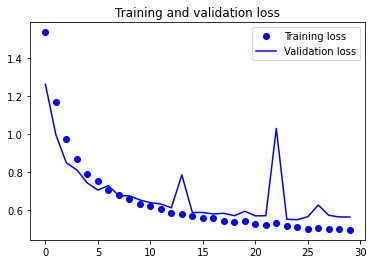

In [8]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [9]:
model = Sequential()
model.add(Embedding(max_words, 8, input_length=maxlen))
model.add(SimpleRNN(32, dropout = 0.35, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 8)            103736    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 200, 32)           1312      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 200, 32)           2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 109,373
Trainable params: 109,373
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=40,
                    batch_size=128,
                    validation_split=0.2)

Train on 35584 samples, validate on 8896 samples
Epoch 1/40
35584/35584 [==============================] - 78s 2ms/sample - loss: 1.5703 - acc: 0.2746 - val_loss: 1.4251 - val_acc: 0.4027
Epoch 2/40
35584/35584 [==============================] - 76s 2ms/sample - loss: 1.2664 - acc: 0.4909 - val_loss: 1.0548 - val_acc: 0.6187
Epoch 3/40
35584/35584 [==============================] - 77s 2ms/sample - loss: 1.0327 - acc: 0.6067 - val_loss: 0.9076 - val_acc: 0.6685
Epoch 4/40
35584/35584 [==============================] - 78s 2ms/sample - loss: 0.8976 - acc: 0.6665 - val_loss: 0.7932 - val_acc: 0.7189
Epoch 5/40
35584/35584 [==============================] - 79s 2ms/sample - loss: 0.8098 - acc: 0.7038 - val_loss: 0.7376 - val_acc: 0.7399
Epoch 6/40
35584/35584 [==============================] - 77s 2ms/sample - loss: 0.7437 - acc: 0.7299 - val_loss: 0.7116 - val_acc: 0.7447
Epoch 7/40
35584/35584 [==============================] - 76s 2ms/sample - loss: 0.6976 - acc: 0.7470 - val_loss: 0.6

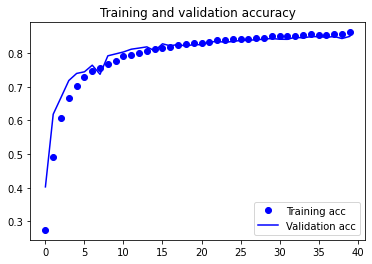

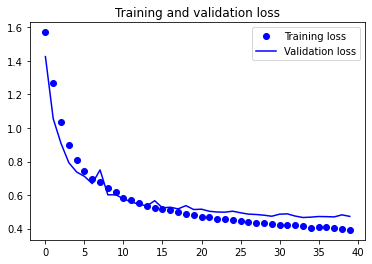

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [12]:
# Save the Model
model.save('simplernn.h5')

### Model #2  (Student Name: Tan Wei Jun)

In [6]:
# Build the Model
model = Sequential()
model.add(layers.Embedding(max_words, 128, input_length=maxlen))
model.add(layers.Conv1D(16, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(5, activation ='softmax'))


model.summary()
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          1659776   
_________________________________________________________________
conv1d (Conv1D)              (None, 194, 16)           14352     
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 85        
Total params: 1,674,213
Trainable params: 1,674,213
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Train the Model
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2)

Train on 35584 samples, validate on 8896 samples
Epoch 1/20
35584/35584 [==============================] - 7s 194us/sample - loss: 1.5973 - acc: 0.2578 - val_loss: 1.5810 - val_acc: 0.3869
Epoch 2/20
35584/35584 [==============================] - 4s 119us/sample - loss: 1.5615 - acc: 0.4917 - val_loss: 1.5434 - val_acc: 0.5327
Epoch 3/20
35584/35584 [==============================] - 4s 117us/sample - loss: 1.5147 - acc: 0.5593 - val_loss: 1.4915 - val_acc: 0.5401
Epoch 4/20
35584/35584 [==============================] - 4s 115us/sample - loss: 1.4548 - acc: 0.5639 - val_loss: 1.4294 - val_acc: 0.5484
Epoch 5/20
35584/35584 [==============================] - 4s 113us/sample - loss: 1.3887 - acc: 0.5760 - val_loss: 1.3666 - val_acc: 0.5673
Epoch 6/20
35584/35584 [==============================] - 4s 114us/sample - loss: 1.3237 - acc: 0.5981 - val_loss: 1.3078 - val_acc: 0.5845
Epoch 7/20
35584/35584 [==============================] - 4s 117us/sample - loss: 1.2623 - acc: 0.6213 - val_lo

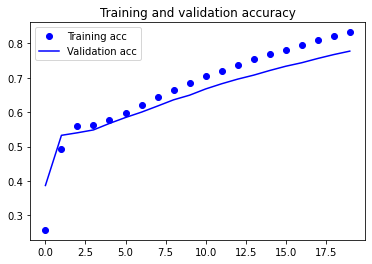

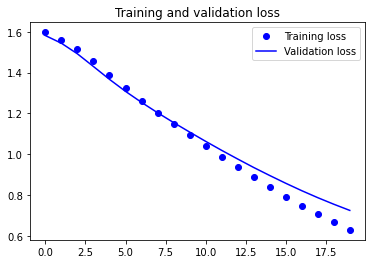

In [8]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [9]:
model = Sequential()
model.add(layers.Embedding(max_words, 128, input_length=maxlen))
model.add(layers.Conv1D(16, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(16, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(5, activation ='softmax'))


model.summary()
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 128)          1659776   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 194, 16)           14352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 38, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 16)            1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 85        
Total params: 1,676,021
Trainable params: 1,676,021
Non-trainable params: 0
____________________________________________

In [10]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2)

Train on 35584 samples, validate on 8896 samples
Epoch 1/20
35584/35584 [==============================] - 5s 136us/sample - loss: 1.6004 - acc: 0.2617 - val_loss: 1.5911 - val_acc: 0.3033
Epoch 2/20
35584/35584 [==============================] - 4s 118us/sample - loss: 1.5777 - acc: 0.3276 - val_loss: 1.5634 - val_acc: 0.3201
Epoch 3/20
35584/35584 [==============================] - 4s 118us/sample - loss: 1.5375 - acc: 0.3789 - val_loss: 1.5087 - val_acc: 0.4065
Epoch 4/20
35584/35584 [==============================] - 4s 118us/sample - loss: 1.4667 - acc: 0.4428 - val_loss: 1.4251 - val_acc: 0.4553
Epoch 5/20
35584/35584 [==============================] - 4s 118us/sample - loss: 1.3765 - acc: 0.4812 - val_loss: 1.3362 - val_acc: 0.4811
Epoch 6/20
35584/35584 [==============================] - 4s 118us/sample - loss: 1.2885 - acc: 0.5163 - val_loss: 1.2599 - val_acc: 0.5163
Epoch 7/20
35584/35584 [==============================] - 4s 120us/sample - loss: 1.2123 - acc: 0.5529 - val_lo

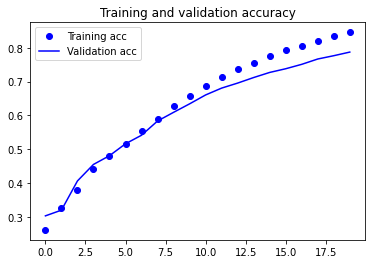

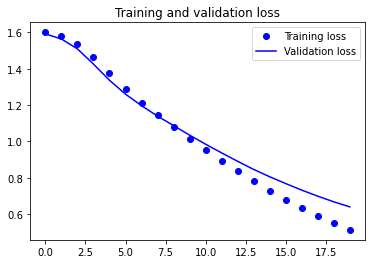

In [11]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [12]:
model = Sequential()
model.add(layers.Embedding(max_words, 128, input_length=maxlen))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(5, activation ='softmax'))


model.summary()
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 128)          1659776   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 194, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 38, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 32, 32)            7200      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 165       
Total params: 1,695,845
Trainable params: 1,695,845
Non-trainable params: 0
____________________________________________

In [13]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_split=0.2)

Train on 35584 samples, validate on 8896 samples
Epoch 1/50
35584/35584 [==============================] - 5s 143us/sample - loss: 1.5962 - acc: 0.3017 - val_loss: 1.5796 - val_acc: 0.3731
Epoch 2/50
35584/35584 [==============================] - 4s 118us/sample - loss: 1.5406 - acc: 0.3998 - val_loss: 1.4841 - val_acc: 0.4224
Epoch 3/50
35584/35584 [==============================] - 4s 124us/sample - loss: 1.4183 - acc: 0.4277 - val_loss: 1.3581 - val_acc: 0.4386
Epoch 4/50
35584/35584 [==============================] - 4s 123us/sample - loss: 1.3144 - acc: 0.4640 - val_loss: 1.2793 - val_acc: 0.4809
Epoch 5/50
35584/35584 [==============================] - 4s 120us/sample - loss: 1.2406 - acc: 0.5116 - val_loss: 1.2182 - val_acc: 0.5189
Epoch 6/50
35584/35584 [==============================] - 4s 119us/sample - loss: 1.1754 - acc: 0.5539 - val_loss: 1.1672 - val_acc: 0.5497
Epoch 7/50
35584/35584 [==============================] - 4s 119us/sample - loss: 1.1150 - acc: 0.5949 - val_lo

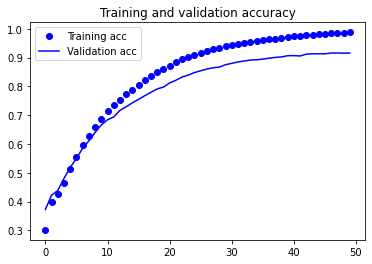

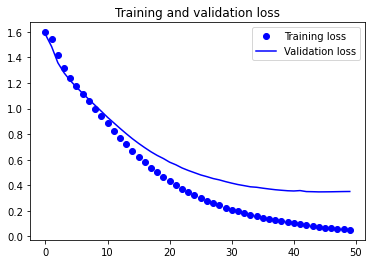

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
model = Sequential()
model.add(layers.Embedding(max_words, 128, input_length=maxlen))
model.add(layers.Conv1D(64, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(64, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(5, activation ='softmax'))


model.summary()
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 128)          1659776   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 194, 64)           57408     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 38, 64)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 32, 64)            28736     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 1,746,245
Trainable params: 1,746,245
Non-trainable params: 0
____________________________________________

In [16]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_split=0.2)

Train on 35584 samples, validate on 8896 samples
Epoch 1/50
35584/35584 [==============================] - 5s 144us/sample - loss: 1.5929 - acc: 0.2877 - val_loss: 1.5676 - val_acc: 0.3116
Epoch 2/50
35584/35584 [==============================] - 4s 119us/sample - loss: 1.4948 - acc: 0.4160 - val_loss: 1.3977 - val_acc: 0.4472
Epoch 3/50
35584/35584 [==============================] - 4s 119us/sample - loss: 1.3367 - acc: 0.4577 - val_loss: 1.2814 - val_acc: 0.4758
Epoch 4/50
35584/35584 [==============================] - 4s 119us/sample - loss: 1.2375 - acc: 0.5124 - val_loss: 1.2056 - val_acc: 0.5180
Epoch 5/50
35584/35584 [==============================] - 4s 119us/sample - loss: 1.1580 - acc: 0.5549 - val_loss: 1.1440 - val_acc: 0.5509
Epoch 6/50
35584/35584 [==============================] - 4s 120us/sample - loss: 1.0860 - acc: 0.5980 - val_loss: 1.0888 - val_acc: 0.5913
Epoch 7/50
35584/35584 [==============================] - 4s 120us/sample - loss: 1.0159 - acc: 0.6356 - val_lo

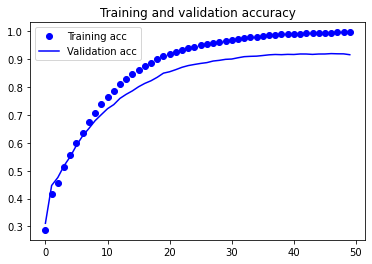

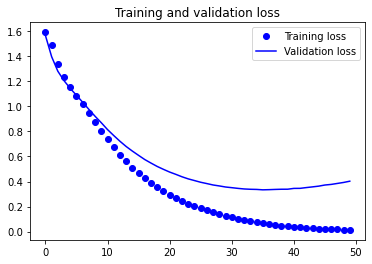

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
model = Sequential()
model.add(layers.Embedding(max_words, 128, input_length=maxlen))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Flatten())
model.add(layers.Dense(32, activation ='relu'))
model.add(layers.Dense(32, activation ='relu'))
model.add(layers.Dense(5, activation ='softmax'))


model.summary()
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 128)          1659776   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 194, 32)           28704     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 38, 32)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 32, 32)            7200      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 32)                0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)               

In [19]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_split=0.2)

Train on 35584 samples, validate on 8896 samples
Epoch 1/50
35584/35584 [==============================] - 5s 145us/sample - loss: 1.5948 - acc: 0.2971 - val_loss: 1.5601 - val_acc: 0.3449
Epoch 2/50
35584/35584 [==============================] - 4s 122us/sample - loss: 1.4705 - acc: 0.3475 - val_loss: 1.3703 - val_acc: 0.3719
Epoch 3/50
35584/35584 [==============================] - 4s 121us/sample - loss: 1.3242 - acc: 0.4004 - val_loss: 1.2764 - val_acc: 0.4318
Epoch 4/50
35584/35584 [==============================] - 4s 120us/sample - loss: 1.2370 - acc: 0.4535 - val_loss: 1.2157 - val_acc: 0.4688
Epoch 5/50
35584/35584 [==============================] - 4s 120us/sample - loss: 1.1619 - acc: 0.5057 - val_loss: 1.1594 - val_acc: 0.5183
Epoch 6/50
35584/35584 [==============================] - 4s 121us/sample - loss: 1.0956 - acc: 0.5582 - val_loss: 1.1108 - val_acc: 0.5599
Epoch 7/50
35584/35584 [==============================] - 4s 120us/sample - loss: 1.0339 - acc: 0.6083 - val_lo

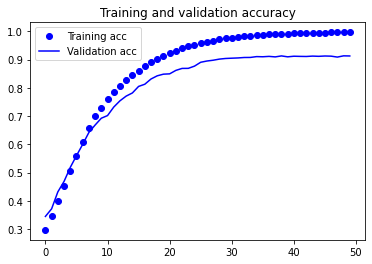

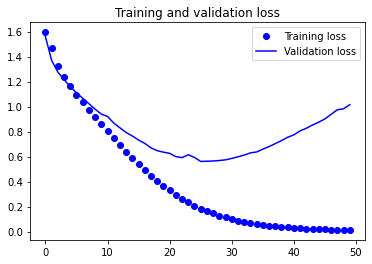

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
model = Sequential()
model.add(layers.Embedding(max_words, 128, input_length=maxlen))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Flatten())
model.add(layers.Dense(32, activation ='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, activation ='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation ='softmax'))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 128)          1659776   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 194, 32)           28704     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 38, 32)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 32, 32)            7200      
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 32)                0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)               

In [22]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_split=0.2)

Train on 35584 samples, validate on 8896 samples
Epoch 1/50
35584/35584 [==============================] - 5s 147us/sample - loss: 1.6082 - acc: 0.2102 - val_loss: 1.6051 - val_acc: 0.2950
Epoch 2/50
35584/35584 [==============================] - 4s 122us/sample - loss: 1.5999 - acc: 0.2422 - val_loss: 1.5898 - val_acc: 0.4134
Epoch 3/50
35584/35584 [==============================] - 4s 120us/sample - loss: 1.5747 - acc: 0.2798 - val_loss: 1.5375 - val_acc: 0.3693
Epoch 4/50
35584/35584 [==============================] - 4s 122us/sample - loss: 1.5118 - acc: 0.3090 - val_loss: 1.4372 - val_acc: 0.3880
Epoch 5/50
35584/35584 [==============================] - 4s 122us/sample - loss: 1.4383 - acc: 0.3455 - val_loss: 1.3559 - val_acc: 0.4014
Epoch 6/50
35584/35584 [==============================] - 4s 121us/sample - loss: 1.3773 - acc: 0.3701 - val_loss: 1.2909 - val_acc: 0.4268
Epoch 7/50
35584/35584 [==============================] - 4s 121us/sample - loss: 1.3180 - acc: 0.3972 - val_lo

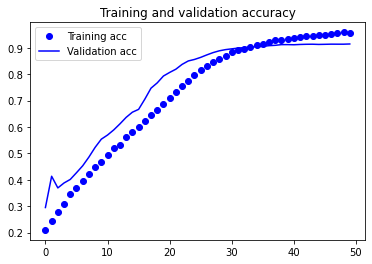

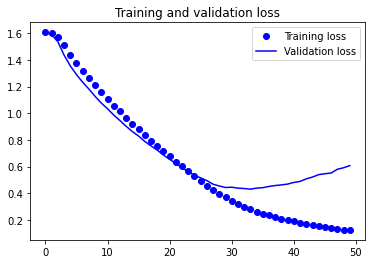

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
model = Sequential()
model.add(layers.Embedding(max_words, 128, input_length=maxlen))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Flatten())
model.add(layers.Dense(32, activation ='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation ='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(5, activation ='softmax'))



model.summary()
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 128)          1659776   
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 194, 32)           28704     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 38, 32)            0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 32, 32)            7200      
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 32)                0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)               

In [25]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_split=0.2)

Train on 35584 samples, validate on 8896 samples
Epoch 1/50
35584/35584 [==============================] - 5s 142us/sample - loss: 1.6048 - acc: 0.2436 - val_loss: 1.5949 - val_acc: 0.3327
Epoch 2/50
35584/35584 [==============================] - 4s 120us/sample - loss: 1.5633 - acc: 0.3275 - val_loss: 1.4970 - val_acc: 0.3662
Epoch 3/50
35584/35584 [==============================] - 4s 121us/sample - loss: 1.4416 - acc: 0.3582 - val_loss: 1.3525 - val_acc: 0.3841
Epoch 4/50
35584/35584 [==============================] - 4s 120us/sample - loss: 1.3479 - acc: 0.3860 - val_loss: 1.2734 - val_acc: 0.4249
Epoch 5/50
35584/35584 [==============================] - 4s 120us/sample - loss: 1.2756 - acc: 0.4207 - val_loss: 1.2113 - val_acc: 0.4638
Epoch 6/50
35584/35584 [==============================] - 4s 120us/sample - loss: 1.2094 - acc: 0.4550 - val_loss: 1.1575 - val_acc: 0.5085
Epoch 7/50
35584/35584 [==============================] - 4s 121us/sample - loss: 1.1456 - acc: 0.4890 - val_lo

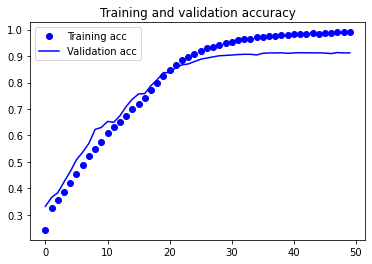

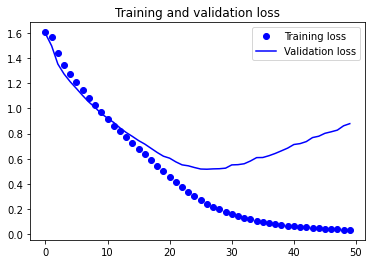

In [26]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [27]:
model = Sequential()
model.add(layers.Embedding(max_words, 128, input_length=maxlen))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Flatten())
model.add(layers.Dense(32, kernel_regularizer=regularizers.l1_l2(l1=1e-3,l2=1e-3), activation ='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, kernel_regularizer=regularizers.l1_l2(l1=1e-3,l2=1e-3), activation ='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(5, activation ='softmax'))

model.summary()
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 200, 128)          1659776   
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 194, 32)           28704     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 38, 32)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 32, 32)            7200      
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 32)                0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)               

In [28]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_split=0.2)

Train on 35584 samples, validate on 8896 samples
Epoch 1/50
35584/35584 [==============================] - 5s 153us/sample - loss: 1.9480 - acc: 0.2415 - val_loss: 1.9090 - val_acc: 0.3491
Epoch 2/50
35584/35584 [==============================] - 4s 121us/sample - loss: 1.8681 - acc: 0.3151 - val_loss: 1.8094 - val_acc: 0.3645
Epoch 3/50
35584/35584 [==============================] - 4s 120us/sample - loss: 1.7409 - acc: 0.3366 - val_loss: 1.6387 - val_acc: 0.3645
Epoch 4/50
35584/35584 [==============================] - 4s 122us/sample - loss: 1.6040 - acc: 0.3599 - val_loss: 1.5190 - val_acc: 0.3956
Epoch 5/50
35584/35584 [==============================] - 4s 122us/sample - loss: 1.5061 - acc: 0.3922 - val_loss: 1.4332 - val_acc: 0.4405
Epoch 6/50
35584/35584 [==============================] - 4s 123us/sample - loss: 1.4235 - acc: 0.4278 - val_loss: 1.3614 - val_acc: 0.4768
Epoch 7/50
35584/35584 [==============================] - 4s 122us/sample - loss: 1.3471 - acc: 0.4580 - val_lo

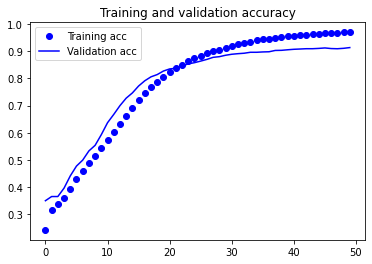

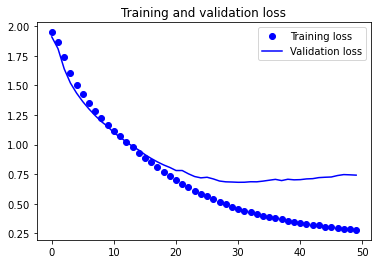

In [29]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [30]:
model = Sequential()
model.add(layers.Embedding(max_words, 128, input_length=maxlen))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Flatten())
model.add(layers.Dense(32, kernel_regularizer=regularizers.l1(0.001), activation ='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, kernel_regularizer=regularizers.l1(0.001), activation ='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(5, activation ='softmax'))

model.summary()
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 200, 128)          1659776   
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 194, 32)           28704     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 38, 32)            0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 32, 32)            7200      
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 32)                0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)               

In [31]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_split=0.2)

Train on 35584 samples, validate on 8896 samples
Epoch 1/50
35584/35584 [==============================] - 5s 152us/sample - loss: 1.8997 - acc: 0.2260 - val_loss: 1.8712 - val_acc: 0.2802
Epoch 2/50
35584/35584 [==============================] - 4s 122us/sample - loss: 1.8432 - acc: 0.2784 - val_loss: 1.8114 - val_acc: 0.3152
Epoch 3/50
35584/35584 [==============================] - 4s 121us/sample - loss: 1.7721 - acc: 0.3271 - val_loss: 1.7121 - val_acc: 0.3668
Epoch 4/50
35584/35584 [==============================] - 4s 122us/sample - loss: 1.6644 - acc: 0.3611 - val_loss: 1.5822 - val_acc: 0.3867
Epoch 5/50
35584/35584 [==============================] - 4s 121us/sample - loss: 1.5563 - acc: 0.3891 - val_loss: 1.4732 - val_acc: 0.4277
Epoch 6/50
35584/35584 [==============================] - 4s 122us/sample - loss: 1.4623 - acc: 0.4197 - val_loss: 1.3893 - val_acc: 0.4508
Epoch 7/50
35584/35584 [==============================] - 4s 122us/sample - loss: 1.3827 - acc: 0.4535 - val_lo

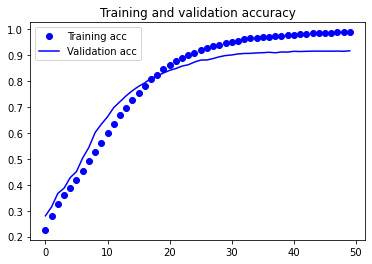

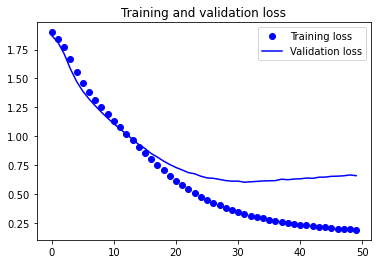

In [32]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [33]:
model = Sequential()
model.add(layers.Embedding(max_words, 128, input_length=maxlen))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Flatten())
model.add(layers.Dense(32, kernel_regularizer=regularizers.l1_l2(l1=1e-3,l2=1e-3), activation ='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, kernel_regularizer=regularizers.l1_l2(l1=1e-3,l2=1e-3), activation ='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation ='softmax'))

model.summary()
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 200, 128)          1659776   
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 194, 32)           28704     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 38, 32)            0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 32, 32)            7200      
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 32)                0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)               

In [34]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_split=0.2)

Train on 35584 samples, validate on 8896 samples
Epoch 1/50
35584/35584 [==============================] - 6s 161us/sample - loss: 1.9361 - acc: 0.2092 - val_loss: 1.9020 - val_acc: 0.2356
Epoch 2/50
35584/35584 [==============================] - 4s 126us/sample - loss: 1.8716 - acc: 0.2312 - val_loss: 1.8415 - val_acc: 0.2759
Epoch 3/50
35584/35584 [==============================] - 4s 123us/sample - loss: 1.8151 - acc: 0.2531 - val_loss: 1.7881 - val_acc: 0.3024
Epoch 4/50
35584/35584 [==============================] - 4s 122us/sample - loss: 1.7624 - acc: 0.2719 - val_loss: 1.7279 - val_acc: 0.3072
Epoch 5/50
35584/35584 [==============================] - 4s 122us/sample - loss: 1.6955 - acc: 0.3060 - val_loss: 1.6379 - val_acc: 0.3258
Epoch 6/50
35584/35584 [==============================] - 4s 122us/sample - loss: 1.6186 - acc: 0.3240 - val_loss: 1.5395 - val_acc: 0.3461
Epoch 7/50
35584/35584 [==============================] - 4s 123us/sample - loss: 1.5455 - acc: 0.3443 - val_lo

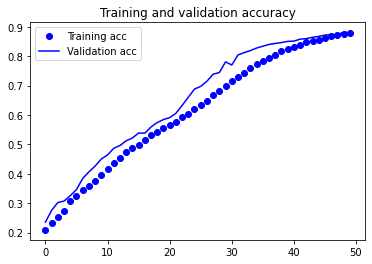

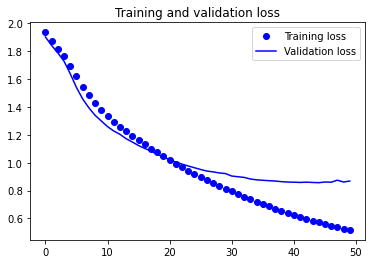

In [35]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [36]:
model = Sequential()
model.add(layers.Embedding(max_words, 128, input_length=maxlen))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Flatten())
model.add(layers.Dense(32, kernel_regularizer=regularizers.l1(0.001), activation ='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, kernel_regularizer=regularizers.l1(0.001), activation ='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation ='softmax'))

model.summary()
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 200, 128)          1659776   
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 194, 32)           28704     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 38, 32)            0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 32, 32)            7200      
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 32)                0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)              

In [37]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_split=0.2)

Train on 35584 samples, validate on 8896 samples
Epoch 1/50
35584/35584 [==============================] - 5s 150us/sample - loss: 1.8886 - acc: 0.2083 - val_loss: 1.8617 - val_acc: 0.2148
Epoch 2/50
35584/35584 [==============================] - 4s 121us/sample - loss: 1.8373 - acc: 0.2312 - val_loss: 1.8131 - val_acc: 0.2458
Epoch 3/50
35584/35584 [==============================] - 4s 121us/sample - loss: 1.7910 - acc: 0.2467 - val_loss: 1.7683 - val_acc: 0.3008
Epoch 4/50
35584/35584 [==============================] - 4s 121us/sample - loss: 1.7478 - acc: 0.2762 - val_loss: 1.7232 - val_acc: 0.3080
Epoch 5/50
35584/35584 [==============================] - 4s 121us/sample - loss: 1.7013 - acc: 0.3103 - val_loss: 1.6705 - val_acc: 0.3911
Epoch 6/50
35584/35584 [==============================] - 4s 123us/sample - loss: 1.6520 - acc: 0.3305 - val_loss: 1.6059 - val_acc: 0.3862
Epoch 7/50
35584/35584 [==============================] - 4s 122us/sample - loss: 1.5856 - acc: 0.3622 - val_lo

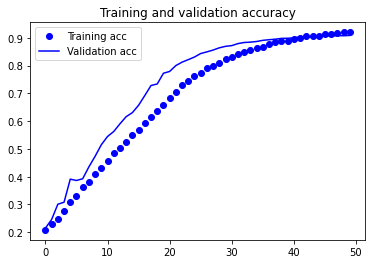

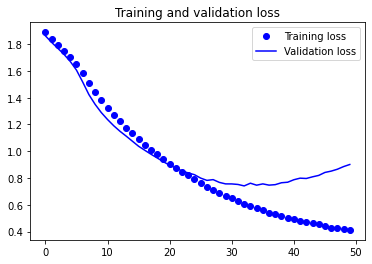

In [38]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [39]:
model = Sequential()
model.add(layers.Embedding(max_words, 128, input_length=maxlen))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Flatten())
model.add(layers.Dense(32, kernel_regularizer=regularizers.l1_l2(l1=1e-3,l2=1e-3), activation ='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(32, kernel_regularizer=regularizers.l1_l2(l1=1e-3,l2=1e-3), activation ='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation ='softmax'))

model.summary()
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 200, 128)          1659776   
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 194, 32)           28704     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 38, 32)            0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 32, 32)            7200      
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 32)                0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 32)              

In [40]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_split=0.2)

Train on 35584 samples, validate on 8896 samples
Epoch 1/50
35584/35584 [==============================] - 6s 155us/sample - loss: 1.9507 - acc: 0.2157 - val_loss: 1.9153 - val_acc: 0.2638
Epoch 2/50
35584/35584 [==============================] - 4s 123us/sample - loss: 1.8837 - acc: 0.2451 - val_loss: 1.8489 - val_acc: 0.2954
Epoch 3/50
35584/35584 [==============================] - 4s 125us/sample - loss: 1.8166 - acc: 0.2821 - val_loss: 1.7700 - val_acc: 0.3504
Epoch 4/50
35584/35584 [==============================] - 5s 127us/sample - loss: 1.7411 - acc: 0.3170 - val_loss: 1.6781 - val_acc: 0.3702
Epoch 5/50
35584/35584 [==============================] - 4s 123us/sample - loss: 1.6647 - acc: 0.3345 - val_loss: 1.5899 - val_acc: 0.3787
Epoch 6/50
35584/35584 [==============================] - 4s 121us/sample - loss: 1.5910 - acc: 0.3523 - val_loss: 1.5067 - val_acc: 0.3873
Epoch 7/50
35584/35584 [==============================] - 4s 122us/sample - loss: 1.5203 - acc: 0.3632 - val_lo

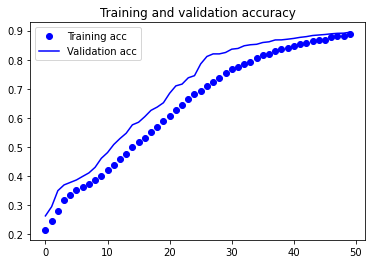

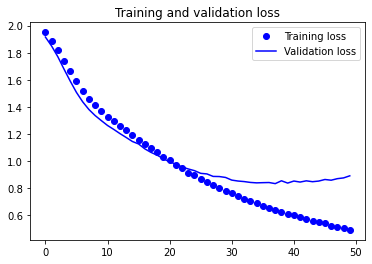

In [41]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [42]:
# Save the Model
model.save('conv1d.h5')

### Model #3  (Student Name: Tan Yong De)

In [43]:
# Build the Model
model = Sequential()
model.add(Embedding(max_words, 16, input_length=maxlen))
model.add(LSTM(1))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 200, 16)           207472    
_________________________________________________________________
lstm (LSTM)                  (None, 1)                 72        
_________________________________________________________________
dense_28 (Dense)             (None, 5)                 10        
Total params: 207,554
Trainable params: 207,554
Non-trainable params: 0
_________________________________________________________________


In [44]:
# Train the Model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Train on 35584 samples, validate on 8896 samples
Epoch 1/10
35584/35584 [==============================] - 19s 523us/sample - loss: 1.5728 - acc: 0.2632 - val_loss: 1.5423 - val_acc: 0.2750
Epoch 2/10
35584/35584 [==============================] - 16s 460us/sample - loss: 1.4839 - acc: 0.3094 - val_loss: 1.4621 - val_acc: 0.3289
Epoch 3/10
35584/35584 [==============================] - 17s 466us/sample - loss: 1.4081 - acc: 0.3413 - val_loss: 1.4186 - val_acc: 0.3242
Epoch 4/10
35584/35584 [==============================] - 17s 465us/sample - loss: 1.3594 - acc: 0.3587 - val_loss: 1.3804 - val_acc: 0.3464
Epoch 5/10
35584/35584 [==============================] - 16s 463us/sample - loss: 1.3247 - acc: 0.3869 - val_loss: 1.3633 - val_acc: 0.4000
Epoch 6/10
35584/35584 [==============================] - 16s 457us/sample - loss: 1.2960 - acc: 0.4146 - val_loss: 1.3361 - val_acc: 0.4139
Epoch 7/10
35584/35584 [==============================] - 16s 462us/sample - loss: 1.2738 - acc: 0.4335 -

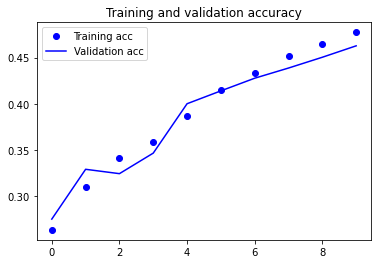

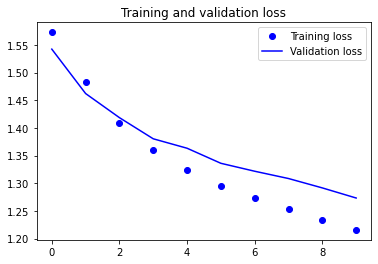

In [45]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [46]:
model = Sequential()
model.add(Embedding(max_words, 16, input_length=maxlen))
model.add(LSTM(24, return_sequences=True))
model.add(LSTM(24))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 200, 16)           207472    
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 24)           3936      
_________________________________________________________________
lstm_2 (LSTM)                (None, 24)                4704      
_________________________________________________________________
dense_29 (Dense)             (None, 5)                 125       
Total params: 216,237
Trainable params: 216,237
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=25,
                    batch_size=32,
                    validation_split=0.2)

Train on 35584 samples, validate on 8896 samples
Epoch 1/25
35584/35584 [==============================] - 39s 1ms/sample - loss: 1.3119 - acc: 0.4192 - val_loss: 1.1887 - val_acc: 0.4960
Epoch 2/25
35584/35584 [==============================] - 36s 1ms/sample - loss: 1.0984 - acc: 0.5616 - val_loss: 1.0796 - val_acc: 0.5843
Epoch 3/25
35584/35584 [==============================] - 36s 1ms/sample - loss: 0.9426 - acc: 0.6458 - val_loss: 0.9671 - val_acc: 0.6377
Epoch 4/25
35584/35584 [==============================] - 36s 1ms/sample - loss: 0.8223 - acc: 0.7013 - val_loss: 0.8827 - val_acc: 0.6739
Epoch 5/25
35584/35584 [==============================] - 36s 1ms/sample - loss: 0.7349 - acc: 0.7382 - val_loss: 0.8059 - val_acc: 0.7141
Epoch 6/25
35584/35584 [==============================] - 36s 1ms/sample - loss: 0.6671 - acc: 0.7669 - val_loss: 0.7509 - val_acc: 0.7356
Epoch 7/25
35584/35584 [==============================] - 35s 998us/sample - loss: 0.6063 - acc: 0.7908 - val_loss: 0

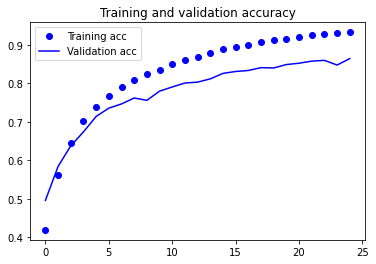

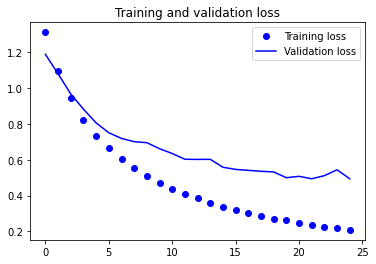

In [48]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [49]:
model = Sequential()
model.add(Embedding(max_words, 16, input_length=maxlen))
model.add(LSTM(24, dropout=0.2, return_sequences=True))
model.add(LSTM(24))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 200, 16)           207472    
_________________________________________________________________
lstm_3 (LSTM)                (None, 200, 24)           3936      
_________________________________________________________________
lstm_4 (LSTM)                (None, 24)                4704      
_________________________________________________________________
dense_30 (Dense)             (None, 5)                 125       
Total params: 216,237
Trainable params: 216,237
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=25,
                    batch_size=32,
                    validation_split=0.2)

Train on 35584 samples, validate on 8896 samples
Epoch 1/25
35584/35584 [==============================] - 41s 1ms/sample - loss: 1.3300 - acc: 0.4089 - val_loss: 1.1940 - val_acc: 0.5109
Epoch 2/25
35584/35584 [==============================] - 37s 1ms/sample - loss: 1.1140 - acc: 0.5487 - val_loss: 1.0574 - val_acc: 0.5873
Epoch 3/25
35584/35584 [==============================] - 36s 1ms/sample - loss: 0.9941 - acc: 0.6136 - val_loss: 0.9779 - val_acc: 0.6292
Epoch 4/25
35584/35584 [==============================] - 36s 1ms/sample - loss: 0.9132 - acc: 0.6536 - val_loss: 0.9285 - val_acc: 0.6529
Epoch 5/25
35584/35584 [==============================] - 36s 1ms/sample - loss: 0.8544 - acc: 0.6829 - val_loss: 0.9167 - val_acc: 0.6556
Epoch 6/25
35584/35584 [==============================] - 36s 1ms/sample - loss: 0.8071 - acc: 0.7032 - val_loss: 0.8607 - val_acc: 0.6841
Epoch 7/25
35584/35584 [==============================] - 36s 1ms/sample - loss: 0.7616 - acc: 0.7220 - val_loss: 0.8

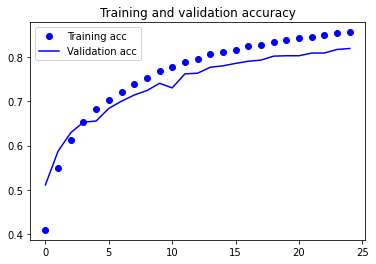

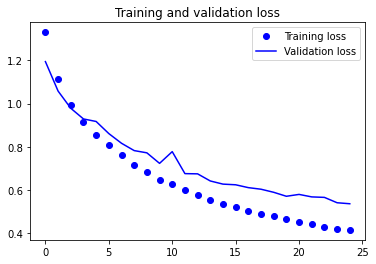

In [51]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [52]:
model = Sequential()
model.add(Embedding(max_words, 16, input_length=maxlen))
model.add(LSTM(32, dropout=0.2, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 200, 16)           207472    
_________________________________________________________________
lstm_5 (LSTM)                (None, 200, 32)           6272      
_________________________________________________________________
lstm_6 (LSTM)                (None, 200, 32)           8320      
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_31 (Dense)             (None, 5)                 165       
Total params: 230,549
Trainable params: 230,549
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2)

Train on 35584 samples, validate on 8896 samples
Epoch 1/100
35584/35584 [==============================] - 58s 2ms/sample - loss: 1.3464 - acc: 0.3899 - val_loss: 1.2648 - val_acc: 0.4459
Epoch 2/100
35584/35584 [==============================] - 52s 1ms/sample - loss: 1.1708 - acc: 0.5152 - val_loss: 1.1530 - val_acc: 0.5452
Epoch 3/100
35584/35584 [==============================] - 52s 1ms/sample - loss: 1.0439 - acc: 0.5909 - val_loss: 1.0310 - val_acc: 0.6050
Epoch 4/100
35584/35584 [==============================] - 52s 1ms/sample - loss: 0.9406 - acc: 0.6439 - val_loss: 0.9869 - val_acc: 0.6181
Epoch 5/100
35584/35584 [==============================] - 52s 1ms/sample - loss: 0.8664 - acc: 0.6763 - val_loss: 0.8748 - val_acc: 0.6794
Epoch 6/100
35584/35584 [==============================] - 52s 1ms/sample - loss: 0.8103 - acc: 0.7028 - val_loss: 0.8558 - val_acc: 0.6875
Epoch 7/100
35584/35584 [==============================] - 52s 1ms/sample - loss: 0.7600 - acc: 0.7231 - val_lo

Epoch 59/100
35584/35584 [==============================] - 53s 1ms/sample - loss: 0.2076 - acc: 0.9296 - val_loss: 0.3950 - val_acc: 0.8878
Epoch 60/100
35584/35584 [==============================] - 52s 1ms/sample - loss: 0.2083 - acc: 0.9285 - val_loss: 0.4056 - val_acc: 0.8891
Epoch 61/100
35584/35584 [==============================] - 52s 1ms/sample - loss: 0.2069 - acc: 0.9306 - val_loss: 0.3857 - val_acc: 0.8912
Epoch 62/100
35584/35584 [==============================] - 52s 1ms/sample - loss: 0.1982 - acc: 0.9334 - val_loss: 0.3952 - val_acc: 0.8926
Epoch 63/100
35584/35584 [==============================] - 52s 1ms/sample - loss: 0.1989 - acc: 0.9334 - val_loss: 0.3908 - val_acc: 0.8906
Epoch 64/100
35584/35584 [==============================] - 52s 1ms/sample - loss: 0.1963 - acc: 0.9347 - val_loss: 0.4066 - val_acc: 0.8921
Epoch 65/100
35584/35584 [==============================] - 52s 1ms/sample - loss: 0.1924 - acc: 0.9357 - val_loss: 0.4010 - val_acc: 0.8915
Epoch 66/100


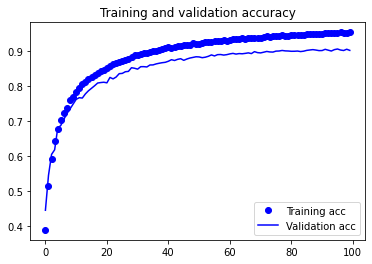

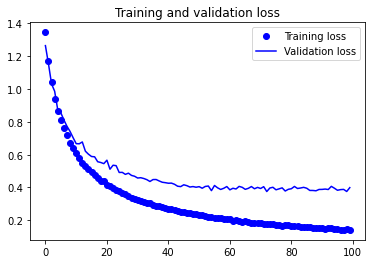

In [54]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [55]:
model = Sequential()
model.add(Embedding(max_words, 16, input_length=maxlen))
model.add(LSTM(32, dropout=0.3, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 200, 16)           207472    
_________________________________________________________________
lstm_8 (LSTM)                (None, 200, 32)           6272      
_________________________________________________________________
lstm_9 (LSTM)                (None, 200, 32)           8320      
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_32 (Dense)             (None, 5)                 165       
Total params: 230,549
Trainable params: 230,549
Non-trainable params: 0
_________________________________________________________________


In [56]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2)

Train on 35584 samples, validate on 8896 samples
Epoch 1/100
35584/35584 [==============================] - 58s 2ms/sample - loss: 1.3510 - acc: 0.3891 - val_loss: 1.2163 - val_acc: 0.4667
Epoch 2/100
35584/35584 [==============================] - 52s 1ms/sample - loss: 1.1801 - acc: 0.5076 - val_loss: 1.1591 - val_acc: 0.5154
Epoch 3/100
35584/35584 [==============================] - 52s 1ms/sample - loss: 1.0688 - acc: 0.5773 - val_loss: 1.0560 - val_acc: 0.5858
Epoch 4/100
35584/35584 [==============================] - 52s 1ms/sample - loss: 0.9855 - acc: 0.6199 - val_loss: 0.9539 - val_acc: 0.6341
Epoch 5/100
35584/35584 [==============================] - 52s 1ms/sample - loss: 0.9157 - acc: 0.6525 - val_loss: 0.9079 - val_acc: 0.6634
Epoch 6/100
35584/35584 [==============================] - 52s 1ms/sample - loss: 0.8533 - acc: 0.6820 - val_loss: 0.8497 - val_acc: 0.6890
Epoch 7/100
35584/35584 [==============================] - 52s 1ms/sample - loss: 0.8059 - acc: 0.7027 - val_lo

Epoch 59/100
35584/35584 [==============================] - 52s 1ms/sample - loss: 0.2871 - acc: 0.9015 - val_loss: 0.4053 - val_acc: 0.8751
Epoch 60/100
35584/35584 [==============================] - 52s 1ms/sample - loss: 0.2862 - acc: 0.9031 - val_loss: 0.4089 - val_acc: 0.8751
Epoch 61/100
35584/35584 [==============================] - 52s 1ms/sample - loss: 0.2819 - acc: 0.9034 - val_loss: 0.4064 - val_acc: 0.8769
Epoch 62/100
35584/35584 [==============================] - 52s 1ms/sample - loss: 0.2745 - acc: 0.9055 - val_loss: 0.4144 - val_acc: 0.8763
Epoch 63/100
35584/35584 [==============================] - 52s 1ms/sample - loss: 0.2724 - acc: 0.9061 - val_loss: 0.4015 - val_acc: 0.8797
Epoch 64/100
35584/35584 [==============================] - 52s 1ms/sample - loss: 0.2730 - acc: 0.9050 - val_loss: 0.4076 - val_acc: 0.8796
Epoch 65/100
35584/35584 [==============================] - 52s 1ms/sample - loss: 0.2705 - acc: 0.9071 - val_loss: 0.4197 - val_acc: 0.8757
Epoch 66/100


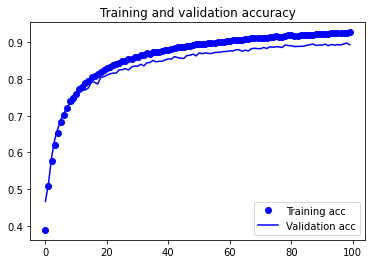

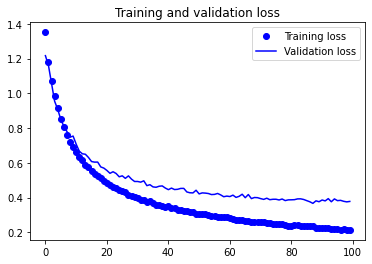

In [57]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [58]:
# Save the Model
model.save('LSTM.h5')

### Model #4  (Student Name: Tan Zi Xu)

In [59]:
# Build the Model
gruModel = Sequential([
    Embedding(max_words, 5, input_length=maxlen),
    GRU(1),
    Dense(5, activation='softmax')
])

gruModel.summary()

gruModel.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 200, 5)            64835     
_________________________________________________________________
gru (GRU)                    (None, 1)                 24        
_________________________________________________________________
dense_33 (Dense)             (None, 5)                 10        
Total params: 64,869
Trainable params: 64,869
Non-trainable params: 0
_________________________________________________________________


In [60]:
# Train the Model
history = gruModel.fit(X_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 35584 samples, validate on 8896 samples
Epoch 1/10
35584/35584 [==============================] - 6s 171us/sample - loss: 1.6068 - acc: 0.2433 - val_loss: 1.6002 - val_acc: 0.2910
Epoch 2/10
35584/35584 [==============================] - 4s 124us/sample - loss: 1.5844 - acc: 0.3031 - val_loss: 1.5661 - val_acc: 0.3020
Epoch 3/10
35584/35584 [==============================] - 4s 124us/sample - loss: 1.5437 - acc: 0.3064 - val_loss: 1.5277 - val_acc: 0.3050
Epoch 4/10
35584/35584 [==============================] - 4s 124us/sample - loss: 1.5034 - acc: 0.3160 - val_loss: 1.4938 - val_acc: 0.3105
Epoch 5/10
35584/35584 [==============================] - 4s 124us/sample - loss: 1.4667 - acc: 0.3265 - val_loss: 1.4631 - val_acc: 0.3219
Epoch 6/10
35584/35584 [==============================] - 4s 125us/sample - loss: 1.4315 - acc: 0.3424 - val_loss: 1.4301 - val_acc: 0.3463
Epoch 7/10
35584/35584 [==============================] - 4s 124us/sample - loss: 1.3942 - acc: 0.3602 - val_lo

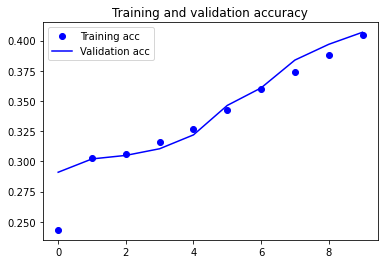

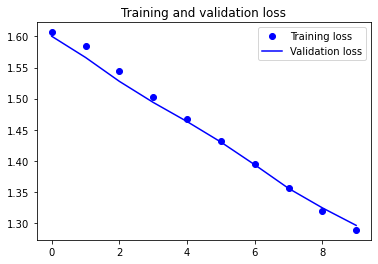

In [61]:
# Plot the Training and Validation Accuracy & Loss Scores
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [62]:
gruModel = Sequential([
    Embedding(max_words, 5, input_length=maxlen),
    GRU(1, return_sequences=True),
    GRU(1),
    Dense(5, activation='softmax')
])

gruModel.summary()

gruModel.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 200, 5)            64835     
_________________________________________________________________
gru_1 (GRU)                  (None, 200, 1)            24        
_________________________________________________________________
gru_2 (GRU)                  (None, 1)                 12        
_________________________________________________________________
dense_34 (Dense)             (None, 5)                 10        
Total params: 64,881
Trainable params: 64,881
Non-trainable params: 0
_________________________________________________________________


In [63]:
history = gruModel.fit(X_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.2)

Train on 35584 samples, validate on 8896 samples
Epoch 1/20
35584/35584 [==============================] - 11s 319us/sample - loss: 1.5973 - acc: 0.2714 - val_loss: 1.5746 - val_acc: 0.3116
Epoch 2/20
35584/35584 [==============================] - 8s 221us/sample - loss: 1.5369 - acc: 0.3183 - val_loss: 1.5062 - val_acc: 0.3309
Epoch 3/20
35584/35584 [==============================] - 8s 225us/sample - loss: 1.4610 - acc: 0.3513 - val_loss: 1.4352 - val_acc: 0.3683
Epoch 4/20
35584/35584 [==============================] - 8s 218us/sample - loss: 1.3903 - acc: 0.3782 - val_loss: 1.3722 - val_acc: 0.3956
Epoch 5/20
35584/35584 [==============================] - 8s 219us/sample - loss: 1.3366 - acc: 0.4018 - val_loss: 1.3276 - val_acc: 0.4060
Epoch 6/20
35584/35584 [==============================] - 8s 220us/sample - loss: 1.2931 - acc: 0.4274 - val_loss: 1.2935 - val_acc: 0.4308
Epoch 7/20
35584/35584 [==============================] - 8s 220us/sample - loss: 1.2591 - acc: 0.4452 - val_l

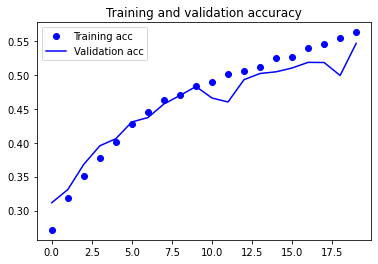

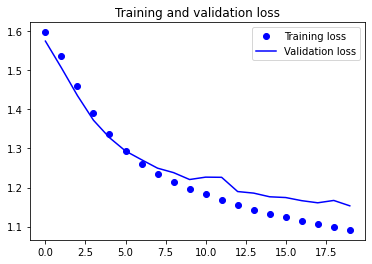

In [64]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [65]:
gruModel = Sequential([
    Embedding(max_words, 5, input_length=maxlen),
    GRU(500, return_sequences=True),
    GRU(500),
    Dense(5, activation='softmax')
])

gruModel.summary()

gruModel.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 200, 5)            64835     
_________________________________________________________________
gru_3 (GRU)                  (None, 200, 500)          760500    
_________________________________________________________________
gru_4 (GRU)                  (None, 500)               1503000   
_________________________________________________________________
dense_35 (Dense)             (None, 5)                 2505      
Total params: 2,330,840
Trainable params: 2,330,840
Non-trainable params: 0
_________________________________________________________________


In [66]:
history = gruModel.fit(X_train, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_split=0.2)

Train on 35584 samples, validate on 8896 samples
Epoch 1/30
35584/35584 [==============================] - 24s 679us/sample - loss: 1.4718 - acc: 0.3214 - val_loss: 1.3967 - val_acc: 0.3518
Epoch 2/30
35584/35584 [==============================] - 20s 570us/sample - loss: 1.2603 - acc: 0.4501 - val_loss: 1.1760 - val_acc: 0.4982
Epoch 3/30
35584/35584 [==============================] - 20s 571us/sample - loss: 1.2001 - acc: 0.5590 - val_loss: 1.0194 - val_acc: 0.6083
Epoch 4/30
35584/35584 [==============================] - 20s 573us/sample - loss: 0.9239 - acc: 0.6489 - val_loss: 0.9273 - val_acc: 0.6551
Epoch 5/30
35584/35584 [==============================] - 20s 573us/sample - loss: 0.7761 - acc: 0.7179 - val_loss: 0.8231 - val_acc: 0.7008
Epoch 6/30
35584/35584 [==============================] - 20s 573us/sample - loss: 0.6586 - acc: 0.7658 - val_loss: 0.7504 - val_acc: 0.7393
Epoch 7/30
35584/35584 [==============================] - 20s 574us/sample - loss: 0.5583 - acc: 0.8068 -

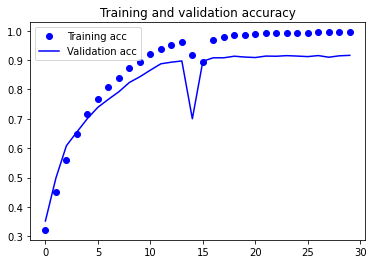

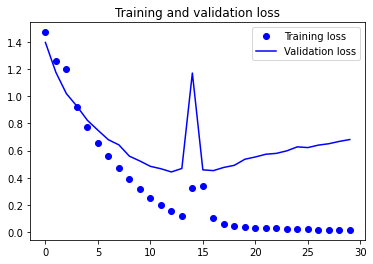

In [67]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [68]:
gruModel = Sequential([
    Embedding(max_words, 5, input_length=maxlen),
    GRU(500, dropout=0.25, return_sequences=True),
    GRU(500),
    Dense(5, activation='softmax')
])

gruModel.summary()

gruModel.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 200, 5)            64835     
_________________________________________________________________
gru_5 (GRU)                  (None, 200, 500)          760500    
_________________________________________________________________
gru_6 (GRU)                  (None, 500)               1503000   
_________________________________________________________________
dense_36 (Dense)             (None, 5)                 2505      
Total params: 2,330,840
Trainable params: 2,330,840
Non-trainable params: 0
_________________________________________________________________


In [69]:
history = gruModel.fit(X_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_split=0.2)

Train on 35584 samples, validate on 8896 samples
Epoch 1/50
35584/35584 [==============================] - 24s 666us/sample - loss: 1.5155 - acc: 0.3179 - val_loss: 1.3669 - val_acc: 0.3817
Epoch 2/50
35584/35584 [==============================] - 21s 580us/sample - loss: 1.3148 - acc: 0.4106 - val_loss: 1.2228 - val_acc: 0.4623
Epoch 3/50
35584/35584 [==============================] - 21s 580us/sample - loss: 1.1849 - acc: 0.4963 - val_loss: 1.0899 - val_acc: 0.5583
Epoch 4/50
35584/35584 [==============================] - 21s 580us/sample - loss: 1.0586 - acc: 0.5735 - val_loss: 1.0325 - val_acc: 0.5831
Epoch 5/50
35584/35584 [==============================] - 21s 579us/sample - loss: 0.9678 - acc: 0.6216 - val_loss: 0.9416 - val_acc: 0.6374
Epoch 6/50
35584/35584 [==============================] - 21s 579us/sample - loss: 0.8900 - acc: 0.6584 - val_loss: 0.8680 - val_acc: 0.6730
Epoch 7/50
35584/35584 [==============================] - 21s 579us/sample - loss: 0.8171 - acc: 0.6924 -

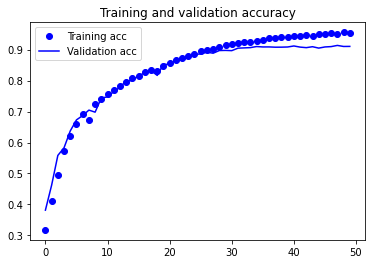

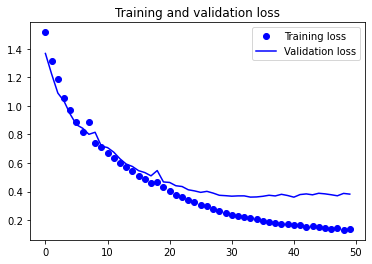

In [70]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [71]:
gruModel = Sequential([
    Embedding(max_words, 5, input_length=maxlen),
    GRU(500, dropout=0.25, return_sequences=True),
    GRU(500),
    Dense(5, activation='softmax')
])

gruModel.summary()

gruModel.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 200, 5)            64835     
_________________________________________________________________
gru_7 (GRU)                  (None, 200, 500)          760500    
_________________________________________________________________
gru_8 (GRU)                  (None, 500)               1503000   
_________________________________________________________________
dense_37 (Dense)             (None, 5)                 2505      
Total params: 2,330,840
Trainable params: 2,330,840
Non-trainable params: 0
_________________________________________________________________


In [72]:
history = gruModel.fit(X_train, y_train,
                    epochs=32,
                    batch_size=128,
                    validation_split=0.2)

Train on 35584 samples, validate on 8896 samples
Epoch 1/32
35584/35584 [==============================] - 25s 696us/sample - loss: 1.5334 - acc: 0.2993 - val_loss: 1.3721 - val_acc: 0.3593
Epoch 2/32
35584/35584 [==============================] - 21s 578us/sample - loss: 1.3295 - acc: 0.3967 - val_loss: 1.2484 - val_acc: 0.4554
Epoch 3/32
35584/35584 [==============================] - 21s 578us/sample - loss: 1.2050 - acc: 0.4804 - val_loss: 1.1524 - val_acc: 0.5028
Epoch 4/32
35584/35584 [==============================] - 21s 579us/sample - loss: 1.1007 - acc: 0.5438 - val_loss: 1.0433 - val_acc: 0.5878
Epoch 5/32
35584/35584 [==============================] - 21s 578us/sample - loss: 1.0041 - acc: 0.6007 - val_loss: 0.9557 - val_acc: 0.6288
Epoch 6/32
35584/35584 [==============================] - 21s 579us/sample - loss: 0.9216 - acc: 0.6403 - val_loss: 0.8992 - val_acc: 0.6551
Epoch 7/32
35584/35584 [==============================] - 21s 579us/sample - loss: 0.8545 - acc: 0.6733 -

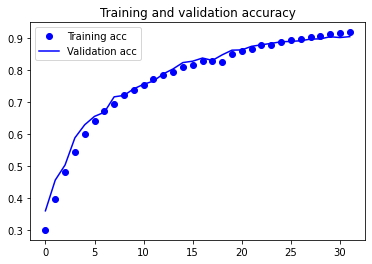

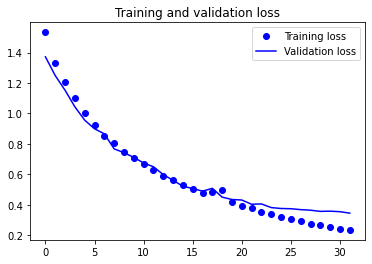

In [73]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [74]:
# Save the Model
gruModel.save('GRU.h5')

## Step 3 – Evaluate the Model using Testing Data (Individual & Group)

Model: SimpleRNN
Test Acc: 0.90881294


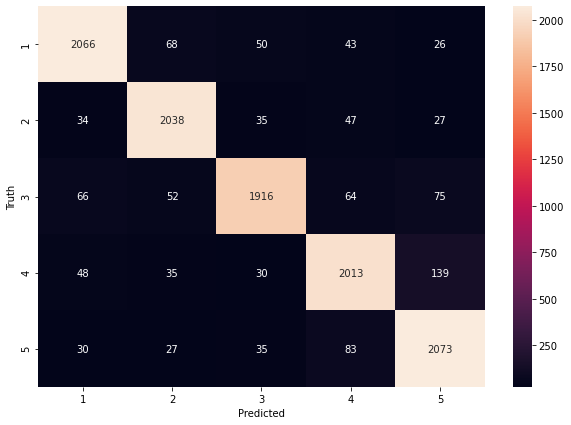

In [29]:
# Model #1 (replicate where necessary for other models)
simplRNN = models.load_model('simplernn.h5')

test_loss, test_acc = simplRNN.evaluate(X_test, y_test, verbose=0)
y_predicted = simplRNN.predict(X_test)
y_predicted_labels=np.array([np.argmax(i) for i in y_predicted])
true_labels = np.argmax(y_test, axis=1)

y_predicted_labels+=1
true_labels+=1
unique_label = np.unique([true_labels, y_predicted_labels])

cm = pd.DataFrame(confusion_matrix(true_labels,y_predicted_labels,labels=unique_label), 
                     index = unique_label, 
                     columns = unique_label)

plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

print('Model: SimpleRNN')
print('Test Acc:', test_acc)

Model: Conv1d
Test Acc: 0.94343525


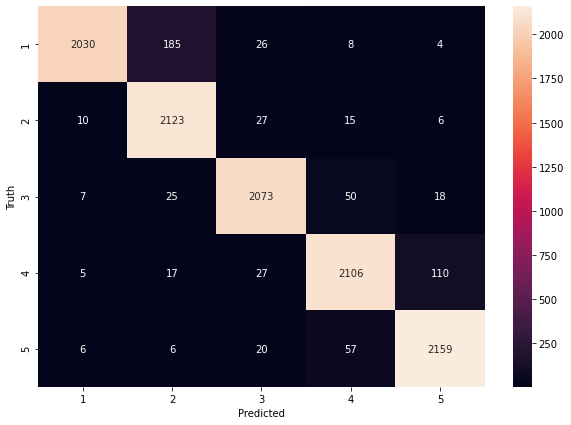

In [30]:
# Model #2 (replicate where necessary for other models)
conv1d = models.load_model('conv1d.h5')

test_loss, test_acc = conv1d.evaluate(X_test, y_test, verbose=0)
y_predicted = conv1d.predict(X_test)
y_predicted_labels=np.array([np.argmax(i) for i in y_predicted])
true_labels = np.argmax(y_test, axis=1)

y_predicted_labels+=1
true_labels+=1
unique_label = np.unique([true_labels, y_predicted_labels])

cm = pd.DataFrame(confusion_matrix(true_labels,y_predicted_labels,labels=unique_label), 
                     index = unique_label, 
                     columns = unique_label)

plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

print('Model: Conv1d')
print('Test Acc:', test_acc)

Model: LSTM
Test Acc: 0.9460432


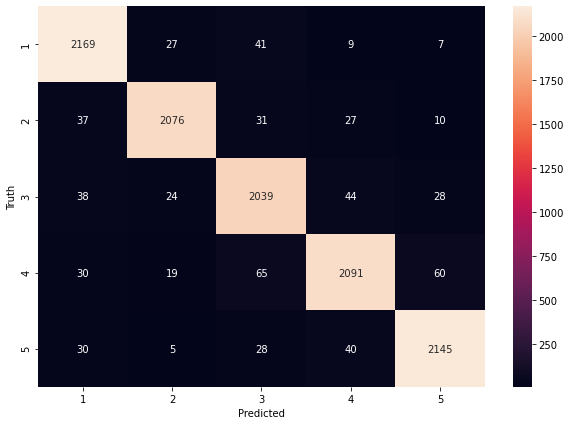

In [31]:
# Model #3 (replicate where necessary for other models)
LSTM = models.load_model('LSTM.h5')

test_loss, test_acc = LSTM.evaluate(X_test, y_test, verbose=0)
y_predicted = LSTM.predict(X_test)
y_predicted_labels=np.array([np.argmax(i) for i in y_predicted])
true_labels = np.argmax(y_test, axis=1)

y_predicted_labels+=1
true_labels+=1
unique_label = np.unique([true_labels, y_predicted_labels])

cm = pd.DataFrame(confusion_matrix(true_labels,y_predicted_labels,labels=unique_label), 
                     index = unique_label, 
                     columns = unique_label)

plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

print('Model: LSTM')
print('Test Acc:', test_acc)

Model: GRU
Test Acc: 0.9551259


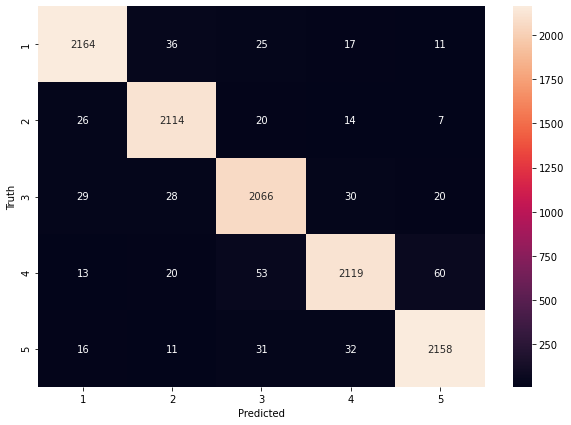

In [32]:
# Model #4 (replicate where necessary for other models)
GRU = models.load_model('GRU.h5')

test_loss, test_acc = GRU.evaluate(X_test, y_test, verbose=0)
y_predicted = GRU.predict(X_test)
y_predicted_labels=np.array([np.argmax(i) for i in y_predicted])
true_labels = np.argmax(y_test, axis=1)

y_predicted_labels+=1
true_labels+=1
unique_label = np.unique([true_labels, y_predicted_labels])

cm = pd.DataFrame(confusion_matrix(true_labels,y_predicted_labels,labels=unique_label), 
                     index = unique_label, 
                     columns = unique_label)

plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

print('Model: GRU')
print('Test Acc:', test_acc)

In [33]:
# Save the Best Model
bestModel = GRU
bestModel.save('bestmodel.h5')

## Step 4 – Use the Best Model to make prediction (Group)

In [9]:
model = models.load_model('bestmodel.h5')

In [30]:
# takes the user input
text_input = np.array([input()])

Multiple documents are unable to send through the whatsapp app, have to send separately one by one. For the past weeks, photos, documents received in the second Sim(Dual Sim) are unable to view and forward. The files, music and documents should be accessed at any time even though deleted by the sender.


In [31]:
# convert the user input into numeric tensor
tokenizer.fit_on_texts(text_input)
sequences = tokenizer.texts_to_sequences(text_input)

data = pad_sequences(sequences, maxlen=maxlen)

In [32]:
# show the model output using predict function
prediction = model.predict(data)
predicted_label = np.argmax(prediction)
print("Predicted score: ",predicted_label+1)

Predicted score:  1


In [23]:
# takes the user input
text_input = np.array([input()])

I love the app. It serves the purpose it was downloaded for. I have a suggestion, when sending a link to someone can the link be grey then once it has been opened it turns blue. Thank you for reading my suggestion and I trust that the creators will get back to me.


In [24]:
# convert the user input into numeric tensor
tokenizer.fit_on_texts(text_input)
sequences = tokenizer.texts_to_sequences(text_input)

data = pad_sequences(sequences, maxlen=maxlen)

In [25]:
# show the model output using predict function
prediction = model.predict(data)
predicted_label = np.argmax(prediction)
print("Predicted score: ",predicted_label+1)

Predicted score:  5
